In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from from_ruth import teff2bv, gyro

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [2]:
'''
using CDS X-Match service
tgas = J/ApJS/211/24/table1 & I/337/tgas
gaia = J/ApJS/211/24/table1 & I/337/gaia
'''

file1 = '1473873638462A.csv'
file2 = '1473873958151A.csv'

In [3]:
tgas = pd.read_csv(file1)
tgas.columns

Index([u'angDist', u'_RAJ2000', u'_DEJ2000', u'KIC', u'Teff', u'log(g)',
       u'Mass', u'Prot', u'e_Prot', u'n_Prot', u'Rper', u'LPH', u'w', u'Ref',
       u'_RA', u'_DE', u'ra_ep2000', u'dec_ep2000', u'errHalfMaj',
       u'errHalfMin', u'errPosAng', u'ra', u'dec', u'hip', u'tycho2_id',
       u'solution_id', u'source_id', u'random_index', u'ref_epoch',
       u'ra_error', u'dec_error', u'parallax', u'parallax_error', u'pmra',
       u'pmra_error', u'pmdec', u'pmdec_error', u'ra_dec_corr',
       u'ra_parallax_corr', u'ra_pmra_corr', u'ra_pmdec_corr',
       u'dec_parallax_corr', u'dec_pmra_corr', u'dec_pmdec_corr',
       u'parallax_pmra_corr', u'parallax_pmdec_corr', u'pmra_pmdec_corr',
       u'astrometric_n_obs_al', u'astrometric_n_obs_ac',
       u'astrometric_n_good_obs_al', u'astrometric_n_good_obs_ac',
       u'astrometric_n_bad_obs_al', u'astrometric_n_bad_obs_ac',
       u'astrometric_delta_q', u'astrometric_excess_noise',
       u'astrometric_excess_noise_sig', u'astromet

In [4]:
gaia = pd.read_csv(file2)
gaia.columns

Index([u'angDist', u'_RAJ2000', u'_DEJ2000', u'KIC', u'Teff', u'log(g)',
       u'Mass', u'Prot', u'e_Prot', u'n_Prot', u'Rper', u'LPH', u'w', u'Ref',
       u'_RA', u'_DE', u'ra_ep2000', u'dec_ep2000', u'errHalfMaj',
       u'errHalfMin', u'errPosAng', u'ra', u'dec', u'source_id', u'ref_epoch',
       u'ra_error', u'dec_error', u'parallax', u'parallax_error', u'pmra',
       u'pmra_error', u'pmdec', u'pmdec_error', u'ra_dec_corr',
       u'duplicated_source', u'phot_g_n_obs', u'phot_g_mean_flux',
       u'phot_g_mean_flux_error', u'phot_g_mean_mag', u'phot_variable_flag',
       u'l', u'b'],
      dtype='object')

In [5]:
print(gaia.shape)
print(tgas.shape)

(41739, 42)
(1303, 80)


/Users/davenpj3/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


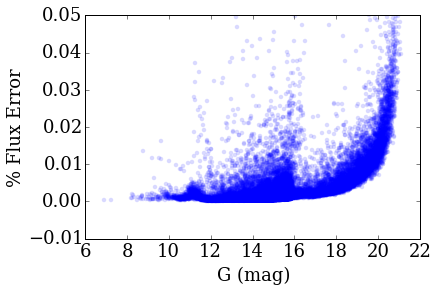

In [6]:
# learn what "good" cuts in Plx and G mag are
plt.scatter(gaia[u'phot_g_mean_mag'], gaia[u'phot_g_mean_flux_error']/gaia[u'phot_g_mean_flux'],
           lw=0, alpha=0.15)
plt.ylim(-.01,.05)
plt.ylabel('% Flux Error')
plt.xlabel('G (mag)')

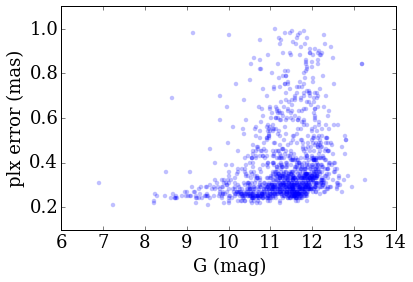

In [7]:
plt.scatter(gaia[u'phot_g_mean_mag'], gaia[u'parallax_error'],
           lw=0, alpha=0.25)
plt.ylabel('plx error (mas)')
plt.xlabel('G (mag)')

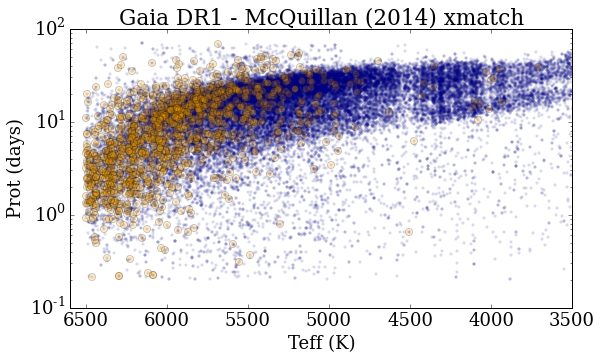

In [8]:
# remake now-famous Kepler gyro diagram
plt.figure(figsize=(9,5))
plt.scatter(gaia[u'Teff'], gaia[u'Prot'], s=10, alpha=0.15, c='navy', lw=0)
plt.scatter(tgas[u'Teff'], tgas[u'Prot'], s=50, alpha=0.2, c='orange')

plt.xlim(6600, 3500)
plt.yscale('log')
plt.xlabel('Teff (K)')
plt.ylabel('Prot (days)')
plt.title('Gaia DR1 - McQuillan (2014) xmatch')

In [9]:
# find the "good" stars, with reasonable Plx and Phot errors

ok = np.where(np.isfinite(gaia[u'parallax']) & # this is basically the same as the TGAS file...
              (gaia[u'parallax_error'] < 0.4) &
              (gaia[u'phot_g_mean_flux_error']/gaia[u'phot_g_mean_flux'] < 0.01))

print(len(ok[0]))

894


<matplotlib.colorbar.Colorbar instance at 0x10703d098>

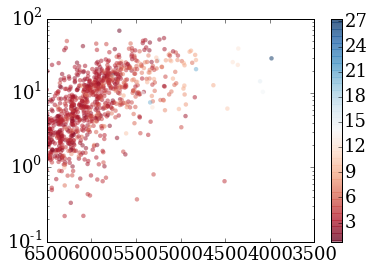

In [10]:
'''
can we explore the bimodality in periods for the M dwarfs?

- NO - ... too few stars with parallax

'''
cm = plt.cm.get_cmap('RdBu')

plt.scatter(gaia[u'Teff'].values[ok], 
            gaia[u'Prot'].values[ok],
            s=20, alpha=0.5, lw=0, cmap=cm, c=(gaia[u'parallax'].values[ok] + 1))
plt.xlim(6500,3500)
# plt.ylim(4,100)
plt.yscale('log')
plt.colorbar()

In [11]:
# whats up with the "variable" flag in Gaia data? spot range?
np.unique(gaia[u'phot_variable_flag'])

# nevermind....

array(['NOT_AVAILABLE'], dtype=object)

In [12]:
# make an HR diagram of rotation period stars!

Mg = gaia[u'phot_g_mean_mag'] + 5. * np.log10(gaia[u'parallax']/1000.)  + 5

## Distances to *Kepler* stars!

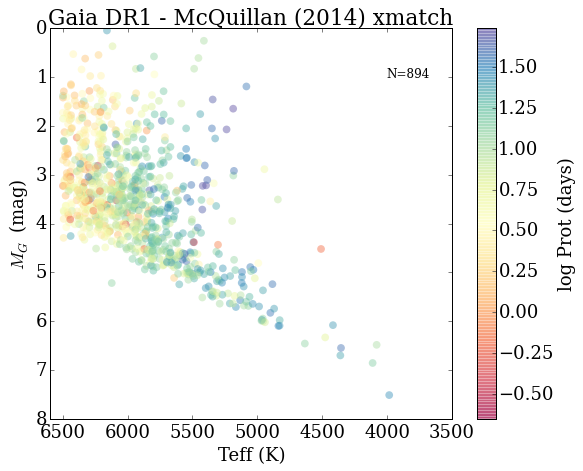

In [13]:
plt.figure(figsize=(9,7))
cm = plt.cm.get_cmap('Spectral')

plt.scatter(gaia[u'Teff'].values[ok], Mg.values[ok], 
            c=np.log10(gaia[u'Prot'].values[ok]),
            lw=0, alpha=0.45, cmap=cm, s=60)

plt.xlim(6600, 3500)
plt.ylim(8, 0)
plt.xlabel('Teff (K)')
plt.ylabel('$M_G$ (mag)')
plt.title('Gaia DR1 - McQuillan (2014) xmatch')
plt.text(4000, 1, 'N=894', fontsize=12)

cb = plt.colorbar()
cb.set_label('log Prot (days)')

In [14]:
# let's put an ischrone down on that figure...
iso_file1 = 'output661464910329.dat' # Padova isochrone, 0.3gyr
iso_file2 = 'output223087321109.dat' # 1.0Gyr
iso_file3 = 'output816153020438.dat' # 4Gyr

In [15]:
names=('Z','log(age)','M_ini', 'M_act','logL/Lo','logTe','logG','mbol','G','G_BP','G_RP','int_IMF','stage')
iso1 = pd.read_table(iso_file1, delim_whitespace=True, header=None, comment='#', names=names)
iso2 = pd.read_table(iso_file2, delim_whitespace=True, header=None, comment='#', names=names)
iso3 = pd.read_table(iso_file3, delim_whitespace=True, header=None, comment='#', names=names)

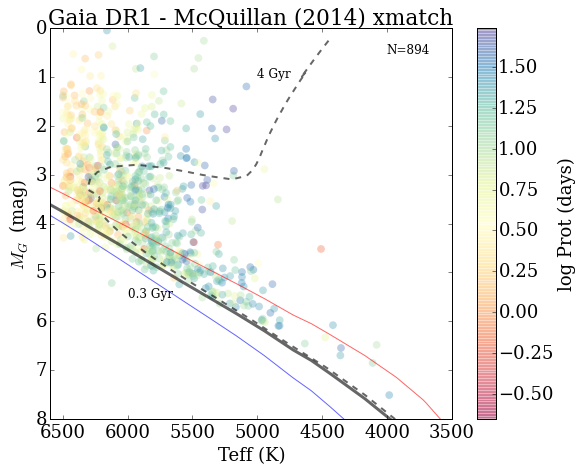

In [16]:
plt.figure(figsize=(9,7))
cm = plt.cm.get_cmap('Spectral')

plt.scatter(gaia[u'Teff'].values[ok], Mg.values[ok], 
            c=np.log10(gaia[u'Prot'].values[ok]),
            lw=0, alpha=0.35, cmap=cm, s=60)

ms = np.where((iso1['stage'] <= 1))
plt.plot(10**iso1['logTe'].values[ms], iso1['G'].values[ms], lw=3, alpha=0.6, c='k')
plt.plot(10**iso1['logTe'].values[ms], iso1['G_BP'].values[ms], lw=1, alpha=0.6, c='b')
plt.plot(10**iso1['logTe'].values[ms], iso1['G_RP'].values[ms], lw=1, alpha=0.6, c='r')

plt.plot(10**iso3['logTe'].values[ms], iso3['G'].values[ms], lw=2, alpha=0.6, c='k', linestyle='dashed')

plt.text(4000,0.5, 'N=894', fontsize=12)
plt.text(5000, 1, '4 Gyr', fontsize=12)
plt.text(6000, 5.5, '0.3 Gyr', fontsize=12)

plt.xlim(6600, 3500)
plt.ylim(8, 0)
plt.xlabel('Teff (K)')
plt.ylabel('$M_G$ (mag)')
plt.title('Gaia DR1 - McQuillan (2014) xmatch')

cb = plt.colorbar()
cb.set_label('log Prot (days)')

In [18]:
Mg_iso = np.interp(gaia[u'Teff'].values[ok], 10**iso1['logTe'].values[ms], iso1['G_RP'].values[ms])
delta_mag = Mg_iso - Mg.values[ok]

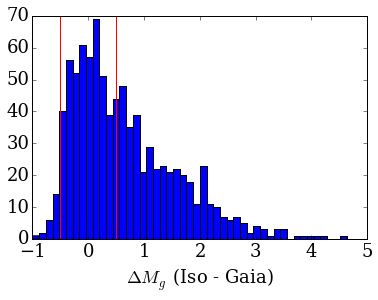

In [57]:
_ = plt.hist(delta_mag, range=(-1,5), bins=50)
plt.xlabel(r'$\Delta M_g$ (Iso - Gaia)')
plt.plot([-.5,-.5], [0,70], c='r')
plt.plot([.5,.5], [0,70], c='r')

In [20]:
# get stars "near" the isochrone
# NOTE: using the 'red' phot channel, because it looks "better"
msok = np.where((delta_mag > -0.5) & 
                (delta_mag < 0.5))

print(len(msok[0]))

443


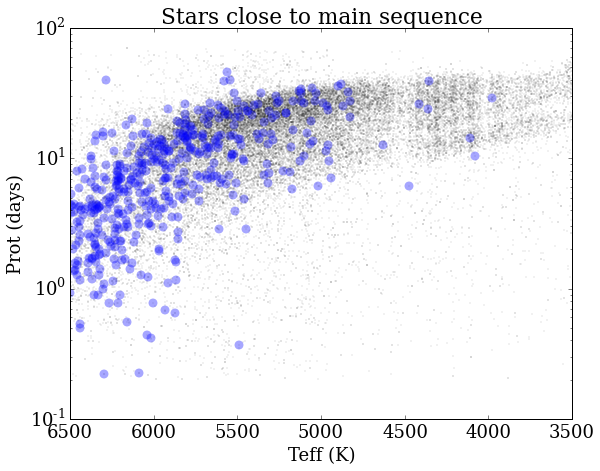

In [21]:
plt.figure(figsize=(9,7))
cm = plt.cm.get_cmap('Spectral')
plt.scatter(gaia[u'Teff'], gaia[u'Prot'], s=2, alpha=0.15, c='k', lw=0)

# plt.scatter(gaia[u'Teff'].values[ok], 
#             gaia[u'Prot'].values[ok],
#             s=10, alpha=0.5, lw=0, c='k')

plt.scatter(gaia[u'Teff'].values[ok][msok], 
            gaia[u'Prot'].values[ok][msok],
            s=80, alpha=0.35, lw=0)

plt.xlim(6500,3500)

plt.yscale('log')
plt.xlabel('Teff (K)')
plt.ylabel('Prot (days)')

plt.title('Stars close to main sequence')

In [74]:
def MM09e2(B_V, age):
    ''' 
    Eqn 2 
    http://adsabs.harvard.edu/abs/2009ApJ...695..679M
    '''
    a = 0.50
    b = 0.15
    P = np.sqrt(age) * (np.sqrt(B_V - a)) - b * (B_V - a)
    return P

def MM09e3(B_V, age):
    ''' Eqn 3 '''
    c = 0.77
    d = 0.40
    f = 0.60
    P = age**0.52 * (c * (B_V - d)**f)
    return P

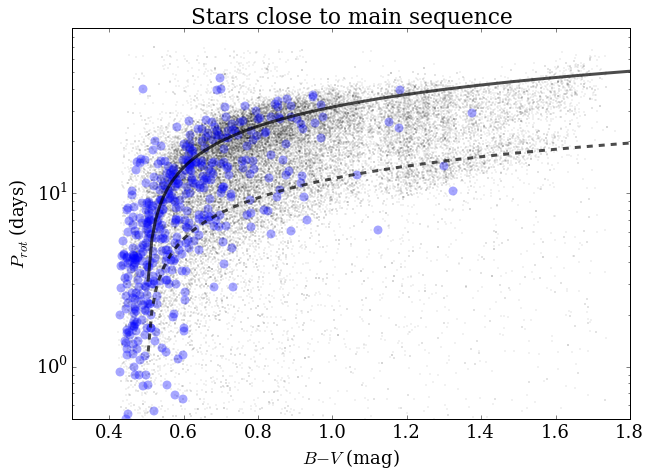

In [86]:
# remake again, but now in B-V units, and with Ruth's isochrone...
B_V = teff2bv(gaia[u'Teff'].values, gaia[u'log(g)'].values, 0)

B_V_iso = np.arange(0.475,2,0.01)
# B_V_iso = np.arange(0.65,2,0.01)
giso1 = gyro(B_V_iso, 500.)
giso2 = gyro(B_V_iso, 3000.)


miso1e2 = MM09e2(B_V_iso, 300)
# miso1e3 = MM09e3(B_V_iso, 500)
miso2e2 = MM09e2(B_V_iso, 2000)
# miso2e3 = MM09e3(B_V_iso, 2000)



plt.figure(figsize=(10,7))
cm = plt.cm.get_cmap('Spectral')
plt.scatter(B_V, gaia[u'Prot'], s=2, alpha=0.15, c='k', lw=0)

plt.scatter(B_V[ok][msok], 
            gaia[u'Prot'].values[ok][msok],
            s=80, alpha=0.35, lw=0)

# plt.plot(B_V_iso, giso1, c='orange', alpha=0.7, lw=3)
# plt.plot(B_V_iso, giso2, c='red', alpha=0.7, lw=3)
# plt.text(1.62, 9, '500 Myr', fontsize=10)
# plt.text(1.67, 27, '3 Gyr', fontsize=10)


plt.plot(B_V_iso, miso1e2, c='k', alpha=0.7, lw=3,linestyle='dashed')
plt.plot(B_V_iso, miso2e2, c='k', alpha=0.7, lw=3)



plt.xlim(0.3,1.8)
plt.ylim(0.5,90)

plt.yscale('log')
plt.xlabel('$B-V$ (mag)')
plt.ylabel('$P_{rot}$ (days)')

plt.title('Stars close to main sequence')

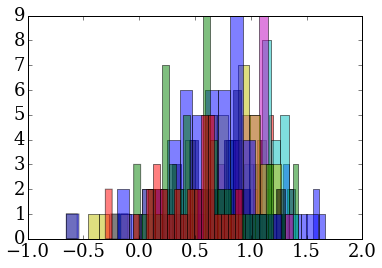

In [68]:
# make histograms of period for bins of temp

for k in range(10):
    x = np.where((gaia[u'Teff'].values[ok][msok] >k*100+5500) & (gaia[u'Teff'].values[ok][msok] <= k*100+5600))
    _ = plt.hist(np.log10(gaia[u'Prot'].values[ok][msok][x]), alpha=0.5, bins=20)

## Thoughts

- we will get almost ALL the Kepler rotation sample in the final Gaia data... just not today
- are we actually grabbing stars near the main sequence?
- could we identify binary systems and remove them?
- is this trimmed down Prot plot useful for redefining gyro relations?

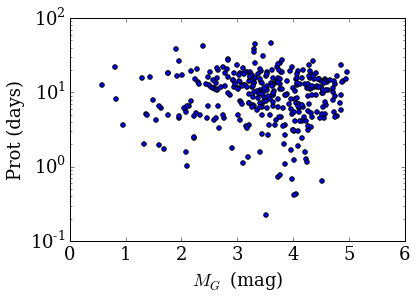

In [22]:
# now make a plot of evolution at a fixed Temp range

Tok = np.where((gaia[u'Teff'].values[ok] >= 5700) & 
               (gaia[u'Teff'].values[ok] <= 6100))

plt.scatter(Mg.values[ok][Tok], gaia[u'Prot'].values[ok][Tok])
plt.xlabel('$M_G$ (mag)')
# plt.xlim(5,0)
plt.yscale('log')
plt.ylabel('Prot (days)')

# hmm... in this Temp range, M_G doesn't track P_rot. Not good measure of post main-sequence evolution I guess.

(0, 2000)

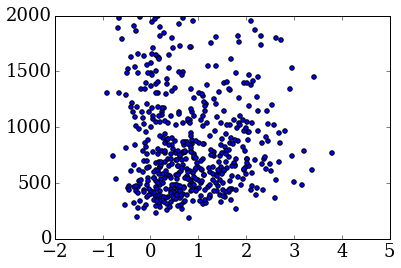

In [23]:
'''
out on a limb now...

Kepler "Range" vs distance from MS
'''

plt.scatter(delta_mag, gaia[u'Rper'].values[ok])
plt.ylim(0, 2000)